1. Load Model

In [ ]:
import torch
from model import CLEAR

input_dim = 2   # hyperparameter of CLEAR                        
model_dim = 32                                     
num_heads = 2
num_layers = 2                                
conv_kernel_size = (17,17)                        
dropout = 0.1
loaded_model = CLEAR(input_dim = input_dim, model_dim = model_dim, num_heads = num_heads, num_layers = num_layers, ff_expansion_factor=4,conv_kernel_size = conv_kernel_size, dropout=dropout)
loaded_model.load_state_dict(torch.load('./best_model/best_model.pth'))



<All keys matched successfully>

2. Perform undersampling on hypercomplex data

In [9]:
import nmrglue as ng
import numpy as np
import scipy.io as scio

def complex2real(fid_3d):
    '''
    Convert a 2D/3D complex array to a 2D/3D real array 
    with an additional dimension for real and imaginary parts.
    '''
    ndim = fid_3d.ndim
    if ndim == 2:
        N1, N2 = fid_3d.shape
        fid_3d_2c = np.zeros([N1, N2, 2])
        fid_3d_2c[:, :, 0] = np.real(fid_3d)
        fid_3d_2c[:, :, 1] = np.imag(fid_3d)

    elif ndim == 3:
        N1, N2, N3 = fid_3d.shape
        fid_3d_2c = np.zeros([N1, N2, N3, 2])
        fid_3d_2c[:, :, :, 0] = np.real(fid_3d)
        fid_3d_2c[:, :, :, 1] = np.imag(fid_3d)
    return fid_3d_2c

def real2complex(fid_3d_2c):
    ndim = fid_3d_2c.ndim
    if ndim ==3:
        N1, N2, _ = fid_3d_2c.shape
        fid_3d = fid_3d_2c[:, :, 0] + 1j * fid_3d_2c[:, :, 1]
    elif ndim ==4:
        N1, N2, N3, _ = fid_3d_2c.shape
        fid_3d = fid_3d_2c[:, :, :, 0] + 1j * fid_3d_2c[:, :, :, 1]
    return fid_3d

def complex2hyper(recon_r,recon_i,data_type,save_hyper_path):
    '''
    Convert two 3D complex arrays 'Xr' and 'Xi' 
    to a 3D hypercomplex array and save it as a ft1 file.
    '''
    N1,N2,N3 = recon_r.shape
    recon_r_tmp = (recon_r + recon_i)/(2.0)
    recon_i_tmp = (recon_r - recon_i)/(2.0j)
    recon_r = recon_r_tmp
    recon_i = recon_i_tmp
    Rr = np.real(recon_r)
    Ri = np.imag(recon_r)
    Ir = np.real(recon_i)
    Ii = np.imag(recon_i)

    r1 = np.arange(0, N1*2, 2)
    i1 = np.arange(1, N1*2, 2)
    r2 = np.arange(0, N2*2, 2)
    i2 = np.arange(1, N2*2, 2)

    hyper_recon = np.zeros([N1*2,N2*2,N3])
    hyper_recon[np.ix_(r1, r2)] = Rr
    hyper_recon[np.ix_(r1, i2)] = Ri
    hyper_recon[np.ix_(i1, r2)] = Ir
    hyper_recon[np.ix_(i1, i2)] = Ii
    Data = hyper_recon.astype(np.float32)
    dic, _ = ng.pipe.read(f"./ft1_Data/{data_type}_hyper.ft1")  # Note: The specified NUS rate (nus_rate) does not affect the result,
                                                                 # as this operation only loads metadata and spectral data from the file.
    ng.pipe.write(save_hyper_path, dic, Data, overwrite=True)

def hyper2complex(data_type):
    '''Convert a 3D hypercomplex array (ft1 file, original fid data processed by NMRPipe script proc_dirct.com)
    to two 3D complex arrays Xr and Xi'''
    _,data = ng.pipe.read(f'./ft1_data/{data_type}_hyper.ft1')

    N1 = data.shape[0]
    N2 = data.shape[1]
    N3 = data.shape[2]

    r1 = np.arange(0, N1, 2)
    i1 = np.arange(1, N1, 2)
    r2 = np.arange(0, N2, 2)
    i2 = np.arange(1, N2, 2)

    Rr = data[np.ix_(r1, r2)]
    Ri = data[np.ix_(r1, i2)]
    Ir = data[np.ix_(i1, r2)]
    Ii = data[np.ix_(i1, i2)]
    fid_r = Rr + 1j*Ri #Rc cos(w1*t1)*exp(1i*w2*t2)
    fid_i = Ir + 1j*Ii #Ic sin(w1*t1)*exp(1i*w2*t2)

    fid_1 = fid_r + 1j*fid_i
    fid_2 = fid_r - 1j*fid_i
    return fid_1, fid_2

def complex_nus(data_type,nus_hyper_path):
    '''Perform non-uniform sampling (NUS) on the complex FID data.'''
    fid_r, fid_i = hyper2complex(data_type=data_type)
    fid_r = fid_r/np.max(np.abs(fid_r))  
    fid_i = fid_i/np.max(np.abs(fid_i)) 
    N1_origin,N2_origin,N3 = fid_r.shape
    
    mask = scio.loadmat(f'./NUS_Mask/mask_{data_type}.mat')['mask']
    print('NUS Sampling Rate:', np.sum(mask)/mask.shape[0]/mask.shape[1])
    mask_3d = np.tile(mask[:, :, np.newaxis], (1, 1, N3))

    fid_r_nus = fid_r * mask_3d
    fid_i_nus = fid_i * mask_3d

    fidr_3d_nus_2c = complex2real(fid_r_nus)
    fidi_3d_nus_2c = complex2real(fid_i_nus)
    complex2hyper(real2complex(fidr_3d_nus_2c),real2complex(fidi_3d_nus_2c),data_type,nus_hyper_path)
    print(f'Saved Processed NUS Hypercomplex {data_type} Data')

data_type = 'PSRP'
nus_hyper_path = f'./NUS_Data/{data_type}_nus.ft1'
complex_nus(data_type,nus_hyper_path)

NUS Sampling Rate: 0.2001953125
Saved Processed NUS Hypercomplex PSRP Data


3.  Data process and spectrum reconstruction

In [ ]:
import numpy as np
import math
import scipy.io as scio
import nmrglue as ng
import time


def nus_proc(data_type):
    '''
    Load NUS hypercomplex data and convert it to two complex arrays
    and their frequency domain representations.
    '''
    _,data = ng.pipe.read(f'./NUS_data/{data_type}_nus.ft1')
    X1 = data.shape[0]
    X2 = data.shape[1]
    X3 = data.shape[2]
    
    r1 = np.arange(0, X1, 2)
    i1 = np.arange(1, X1, 2)
    r2 = np.arange(0, X2, 2)
    i2 = np.arange(1, X2, 2)
    
    Rr = data[np.ix_(r1, r2)]
    Ri = data[np.ix_(r1, i2)]
    Ir = data[np.ix_(i1, r2)]
    Ii = data[np.ix_(i1, i2)]
    
    fid1 = Rr + 1j*Ri #Rc cos(w1*t1)*exp(1i*w2*t2)
    fid2 = Ir + 1j*Ii #Ic sin(w1*t1)*exp(1i*w2*t2)

    fid_r = fid1+1j*fid2
    fid_i = fid1-1j*fid2

    fid_r_nus = fid_r/np.max(np.abs(fid_r)) 
    fid_i_nus = fid_i/np.max(np.abs(fid_i)) 
    N1_origin,N2_origin,N3 = fid_r.shape

    size_0 = 64
    size_1 = 64

    N1_pad = math.ceil(N1_origin / size_0) * size_0
    N2_pad = math.ceil(N2_origin / size_1) * size_1
    mask = scio.loadmat(f'./NUS_Mask/mask_{data_type}.mat')['mask']

    mask_2c = np.tile(mask[:, :, np.newaxis], (1, 1, 2))
    mask_3d = np.tile(mask[:, :, np.newaxis], (1, 1, N3))

    fidr_3d_origin_2c     = complex2real(fid_r)
    fidr_3d_nus_origin_2c = complex2real(fid_r_nus)
    fidr_3d_nus_2c_pad = np.zeros([N1_pad, N2_pad, N3, 2])
    fidr_3d_nus_2c_pad[:N1_origin, :N2_origin, :, :] = fidr_3d_nus_origin_2c

    fidi_3d_origin_2c     = complex2real(fid_i)
    fidi_3d_nus_origin_2c = complex2real(fid_i_nus)
    fidi_3d_nus_2c_pad = np.zeros([N1_pad, N2_pad, N3, 2])
    fidi_3d_nus_2c_pad[:N1_origin, :N2_origin, :, :] = fidi_3d_nus_origin_2c

    fr_nus_2c = np.zeros([N1_pad, N2_pad, N3, 2])
    fi_nus_2c = np.zeros([N1_pad, N2_pad, N3, 2])
    fr_2c = np.zeros([N1_pad, N2_pad, N3, 2])
    fi_2c = np.zeros([N1_pad, N2_pad, N3, 2])
    for i in range(N3):
        fr_nus_2c[:N1_origin,:N2_origin,i,:] = complex2real(np.fft.fft2(np.squeeze(fid_r_nus[:,:,i])))
        fi_nus_2c[:N1_origin,:N2_origin,i,:] = complex2real(np.fft.fft2(np.squeeze(fid_i_nus[:,:,i])))
        fr_2c[:N1_origin,:N2_origin,i,:] = complex2real(np.fft.fft2(np.squeeze(fid_r[:,:,i])))
        fi_2c[:N1_origin,:N2_origin,i,:] = complex2real(np.fft.fft2(np.squeeze(fid_i[:,:,i])))

    return fidr_3d_nus_2c_pad, fidr_3d_nus_origin_2c,fr_nus_2c, fr_2c, fidi_3d_nus_2c_pad, fidi_3d_nus_origin_2c, fi_nus_2c, fi_2c,mask_2c



if __name__ == '__main__':

    data_type = 'PSRP'  # 'A3DK08',  'Yfgj',  'PSRP'
    print(torch.cuda.is_available())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model = loaded_model.to(device)
    loaded_model.eval()

    fidr_3d_nus_2c_pad, fidr_3d_nus_origin_2c, fr_nus_2c, fr_2c, fidi_3d_nus_2c_pad, fidi_3d_nus_origin_2c, fi_nus_2c, fi_2c,mask_2c = nus_proc(data_type)
    N1,N2,N3,_ = fr_nus_2c.shape
    N1_origin,N2_origin,_,_ = fidr_3d_nus_origin_2c.shape
    recon_result = np.zeros((N1,N2,N3),dtype = complex)
    iz1 = 1
    iz2 = N3
    start = time.perf_counter()
    for recon_step in ['Xr', 'Xi']:
        mask = torch.tensor(mask_2c, dtype=torch.float32)
        if recon_step == 'Xr':
            f_nus_2c = fr_nus_2c
            fid_3d_nus_2c = fidr_3d_nus_origin_2c
            f_2c = fr_2c
        elif recon_step == 'Xi':
            f_nus_2c = fi_nus_2c
            fid_3d_nus_2c = fidi_3d_nus_origin_2c
            f_2c = fi_2c
        for i in range (iz1,iz2):
            test_input     =      f_nus_2c[:,:,i,:]
            sampled_signal = fid_3d_nus_2c[:,:,i,:]
            test_input = test_input.reshape(1,N1,N2,2)
            sampled_signal = sampled_signal.reshape(1,N1_origin,N2_origin,2)
            test_input     = torch.tensor(test_input, dtype=torch.float32)  
            sampled_signal = torch.tensor(sampled_signal, dtype=torch.float32)
            test_input = test_input.to(device)
            sampled_signal = sampled_signal.to(device)
            mask = mask.to(device)
            with torch.no_grad():
                output2 = loaded_model.forward(test_input,sampled_signal,mask=mask)
            f_pre = output2.detach().cpu().numpy().reshape(N1,N2,2)   # output of second phase       
            out = f_pre[:,:,0]+1j*f_pre[:,:,1]
            recon_result[:,:,i] = out.squeeze()
        end = time.perf_counter()
        recon_result_t = np.zeros((N1_origin,N2_origin,N3),dtype = complex)
        for i in range (iz1,iz2):
            recon_result_t[:,:,i] = np.fft.ifft2(recon_result[0:N1_origin,0:N2_origin,i].squeeze())
        if recon_step == 'Xr':
            recon_r = recon_result_t
        elif recon_step == 'Xi':
            recon_i = recon_result_t
    recon_hyper_path = f"./Recon_Results/{data_type}_recon.ft1"
    complex2hyper(recon_r,recon_i,data_type,recon_hyper_path)
    print(f'Reconstruction time: {(end-start):.2f}s\n')

True
Reconstruction time: 12.03s



Draw contour figures of reconstructed spectrum processed in NMRpipe

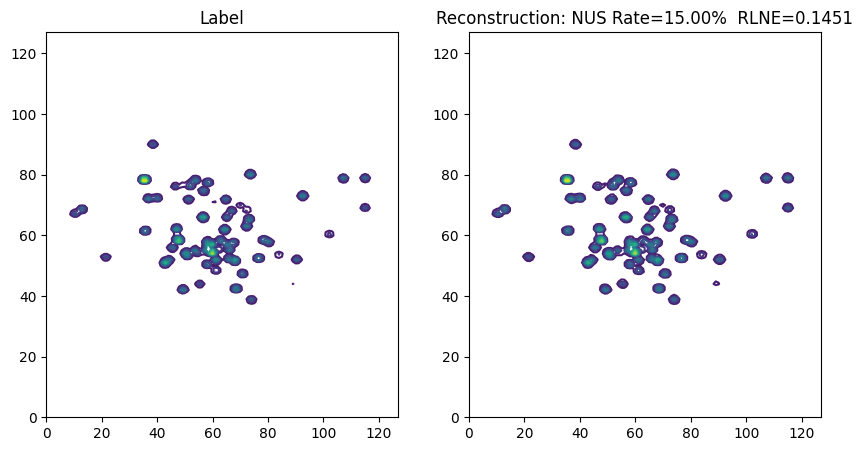

In [1]:
import nmrglue as ng
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio

def compute_rlne(x_true, x_pred):

        x_pred = np.array(x_pred)
        x_true = np.array(x_true)
        l2_error = np.linalg.norm(x_pred - x_true, ord=2)
        l2_true = np.linalg.norm(x_true, ord=2)
        rlne = l2_error / l2_true
        return rlne

def iz1_izn(data_type):
    '''
    Select the range of direct dimension projection
    '''
    if data_type == 'PSRP':
        iz1 = 80
        izn = 180
    elif data_type == 'A3DK08':
        iz1 = 60
        izn = 180
    elif data_type == 'Yfgj':
        # iz1 = 130
        # izn = 220
        iz1 = 1
        izn = 512
    return iz1,izn

def projection_3d(data,projection_type = 'skyline',iz1 = 1,izn = 512):
    '''
    Perform projection of 3D data along the direct dimension.
    '''
    if projection_type == 'skyline':
        return np.max(data[:,iz1-1:izn-1,:],1)/np.max(np.max(data[:,iz1-1:izn-1,:],1))

    elif projection_type == 'sum':
        return np.abs(np.sum(data[:,:,iz1-1:izn-1],2))

if __name__ == '__main__':
    data_type = 'A3DK08'  # 'A3DK08',  'Yfgj',  'PSRP'
    iz1,izn = iz1_izn(data_type)
    dic,data_label = ng.pipe.read(f"./Recon_Results/{data_type}_label.ft")
    spec_origin = projection_3d(data_label,projection_type='skyline',iz1=iz1,izn=izn)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.contour(spec_origin,cmap='viridis',levels=12)
    plt.title('Label')

    mask = scio.loadmat(f'./NUS_Mask/mask_{data_type}.mat')['mask']
    sample_rate =  np.sum(mask)/mask.shape[0]/mask.shape[1]*100
    dic,data_recon = ng.pipe.read(f'./Recon_Results/{data_type}_recon.ft')
    spec_recon   = projection_3d(data_recon,projection_type='skyline',iz1=iz1,izn=izn)
    
    plt.subplot(1,2,2)
    plt.contour(spec_recon,cmap='viridis',levels=12)
    plt.title(f'Reconstruction: NUS Rate={sample_rate:.2f}%  RLNE={compute_rlne(spec_origin, spec_recon):.4f}')
    plt.show()


